In [1]:
import os, os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import ipywidgets as widgets
from IPython.display import clear_output
from pathlib import Path
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

plt.rcParams['figure.figsize'] = [20, 10]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/casbertrams/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
dataPath = os.getcwd() + '/data/data3/'
caseCount = len(os.listdir(dataPath))
data = []
try:
    os.remove(dataPath + ".DS_Store")
except:
    print("No file DS_Store")
for filename in os.listdir(dataPath):
    f = open(os.path.join(dataPath, filename), encoding='utf-8')
    data.append([filename.replace('.txt', ''), f.read()])

verdict_df = pd.DataFrame(data, columns=['Case ID', 'Case Text'])
cases_df = pd.read_csv('./cases3.csv', usecols = ['GerechtelijkProductType', 'Case ID', 'Proceduresoorten', 'Publicatiedatum', 'Rechtsgebieden', 'Tekstfragment', 'Titel', 'Uitspraakdatum', 'UitspraakdatumType'])
merged_df = cases_df.join(verdict_df.set_index('Case ID'), on='Case ID', how='left')

No file DS_Store


In [3]:
def count_mentions(word_arr):
    dates = []
    counts = []
    for i in range(len(merged_df)):
        current = merged_df.iloc[i]
        current_date = current["Uitspraakdatum"]
        
        current_case_text = current['Case Text']
        occurrences = 0
        for i in word_arr:
            occurrences = occurrences + current_case_text.lower().count(i.lower())
        dates.append(current_date)
        counts.append(occurrences)

    dates = pd.Series(dates)
    counts = pd.Series(counts)
    frame = { 'date': dates, 'count': counts }
    results = pd.DataFrame(frame)
    return results

In [4]:
def count_cases(word_arr):
    dates = []
    counts = []
    for i in range(len(merged_df)):
        current = merged_df.iloc[i]
        current_date = current['Uitspraakdatum']
        current_case_text = current['Case Text']
        occurrences = 0
        if any(x.lower() in current_case_text.lower() for x in word_arr):
            occurrences = 1
        dates.append(current_date)
        counts.append(occurrences)
    
    dates = pd.Series(dates)
    counts = pd.Series(counts)
    frame = { 'date': dates, 'count': counts }
    results = pd.DataFrame(frame)
    return results

In [5]:
mdma_results = count_mentions(['XTC'])
mdma_results.set_index('date', inplace=True)
mdma_results.index = pd.to_datetime(mdma_results.index)
daily_mdma_result = mdma_results.resample('1M').sum()

mdma_cases_results = count_cases(['XTC'])
mdma_cases_results.set_index('date', inplace=True)
mdma_cases_results.index = pd.to_datetime(mdma_cases_results.index)
daily_mdma_cases_result = mdma_cases_results.resample('1M').sum()

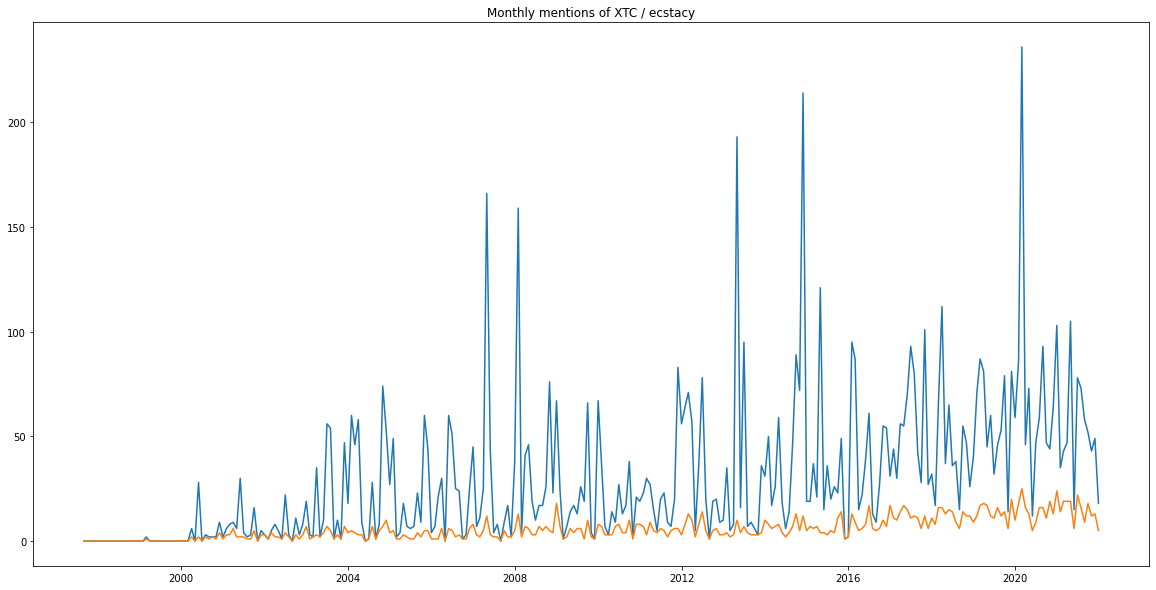

In [6]:
plt.plot(daily_mdma_result[220:])
plt.plot(daily_mdma_cases_result[220:])

plt.title("Monthly mentions of XTC / ecstacy")
plt.show()

<h3>Term Frequency - Inverse Document Frequency </h3>
Each term is weighted by dividing the term frequency by the number of documents in the corpus containing the word 

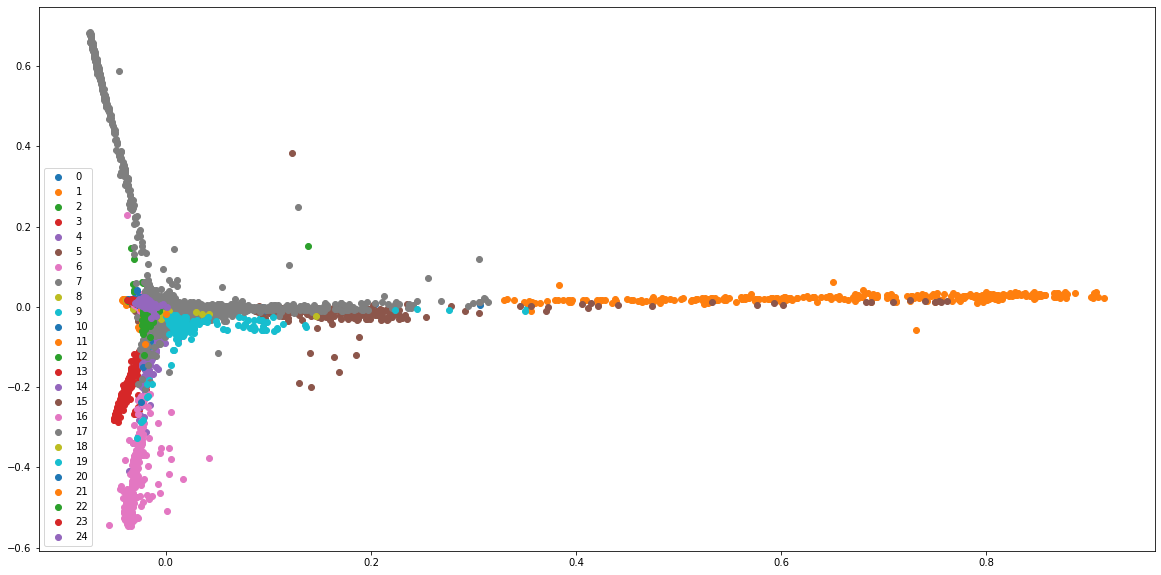

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA


documents = merged_df["Case Text"]
total_stop_words = stopwords.words('dutch') + stopwords.words('english')
vectorizer = TfidfVectorizer(max_df=0.05, min_df=10, stop_words=total_stop_words , use_idf=True,  lowercase=True)

X = vectorizer.fit_transform(documents)
X = X.astype('float32')

true_k = 25
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200)

labels = model.fit_predict(X)
merged_df["K means cluster"] = labels

X_array = X.toarray()
pca = PCA(n_components=2).fit(X_array)
XPCA = pca.transform(X_array)

u_labels = np.unique(labels)
for i in u_labels:
    plt.scatter(XPCA[labels == i , 0] , XPCA[labels == i , 1] , label = i)
plt.legend()
plt.show()


In [32]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
terms_df = pd.DataFrame()
for i in range(true_k):
    curr = []
    for ind in order_centroids[i, :19]:
        curr.append(terms[ind])
    terms_df[i] = curr

print(terms_df)
terms_df.to_csv("kmeans/K-means top terms per cluster " + str(true_k) + " clusters.csv")


Top terms per cluster:
                          0                       1                2   \
0              jeugddetentie  terbeschikkinggestelde        container   
1          jeugdreclassering              verpleging       containers   
2                   bijstand           overheidswege        antwerpen   
3                        pij         dwangverpleging           lading   
4                        wwb                  verlof              ect   
5              kinderrechter               verlengen      vrachtwagen   
6                       77aa             proefverlof        ananassen   
7                appellanten          resocialisatie            schip   
8            jeugdstrafrecht             transmuraal  containernummer   
9   inlichtingenverplichting                     fpc        verlengde   
10         kinderbescherming   resocialisatietraject        belgische   
11                   overval                     38d           douane   
12                       77g

In [ ]:
# make the output folder if it doesn't already exist
Path("./tf_idf_output").mkdir(parents=True, exist_ok=True)

# construct a list of output file paths using the previous list of text files the relative path for tf_idf_output
output_filenames = ["tf_idf_output/" + file + '.csv' for file in merged_df['Case ID']]
output_dates = [date for date in merged_df['Uitspraakdatum']]

tf_idf_df = []

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    d = {
        "Case ID": output_filenames[counter],
        "Date": output_dates[counter],
        "1": one_doc_as_df.iloc[0].term,
        "1 score": one_doc_as_df.iloc[0].score,
        "2": one_doc_as_df.iloc[1].term,
        "2 score": one_doc_as_df.iloc[1].score,
        "3": one_doc_as_df.iloc[2].term,
        "3 score": one_doc_as_df.iloc[2].score,
        "4": one_doc_as_df.iloc[3].term,
        "4 score": one_doc_as_df.iloc[3].score,
        "5": one_doc_as_df.iloc[4].term,
        "5 score": one_doc_as_df.iloc[4].score,
        "6": one_doc_as_df.iloc[5].term,
        "6 score": one_doc_as_df.iloc[5].score,
        "7": one_doc_as_df.iloc[6].term,
        "7 score": one_doc_as_df.iloc[6].score,
        "8": one_doc_as_df.iloc[7].term,
        "8 score": one_doc_as_df.iloc[7].score,
        "9": one_doc_as_df.iloc[8].term,
        "9 score": one_doc_as_df.iloc[8].score,
        "10": one_doc_as_df.iloc[9].term,
        "10 score": one_doc_as_df.iloc[9].score
    }
    tf_idf_df.append(d)
    one_doc_as_df.to_csv(output_filenames[counter])
    
tf_idf_df = pd.DataFrame(tf_idf_df)
print(tf_idf_df)

In [14]:
tf_idf_df.to_csv("copmlete_tf_idf_df.csv")

NameError: name 'tf_idf_df' is not defined

In [16]:
tf_idf_df = pd.read_csv("copmlete_tf_idf_df.csv")
print(tf_idf_df.iloc[0])

FileNotFoundError: [Errno 2] No such file or directory: 'copmlete_tf_idf_df.csv'